# STREAM benchmark

Results from STREAM benchmark.

In [1]:
import os, sys
from pprint import pprint
from pathlib import Path

REPO_ROOT = str(Path(os.getcwd()).parent.parent.parent.parent)  # Repo root dir
REFRAME_ROOT = os.path.join(REPO_ROOT, 'reframe')  # ReFrame root dir
REFRAME_DEPS = os.path.join(REFRAME_ROOT, 'external')  # ReFrame dependencies
REPO_DEPS = os.path.join(REPO_ROOT, 'external')  # Repo dependencies
PERFLOG_DIR = os.path.join(REPO_ROOT, 'perflogs')  # Perflogs dir
sys.path.extend((REFRAME_ROOT, REPO_ROOT, REPO_DEPS, REFRAME_DEPS)) # the `modules` package imports `reframe` so need that in sys.modules

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import modules
from reframe_config import site_configuration

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, HTML

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## Systems and their descriptions

The following table gives a high level overview of each partition defined in terms of architecture and configuration. The column `S:C:T` stands for **number of sockets**, **number of physical cores per socket** and **number of threads per core**. Similarly, the column `caches` indicate the cache sizes from lower to higher in bytes.

In [3]:
df = modules.utils.tabulate_partitions(root=PERFLOG_DIR)
display(HTML(df.transpose().to_html()))

## Array size

STREAM benchmark uses 3 arrays of size `N` to run different kernels. We use the total array size of the benchmark in such a way that they occupy 60% of the system memory to avoid caching effects of the benchmark.

## Latest run performance metrics

All the performance metrics are tabulated from the latest benchmark run for different systems/parititons and programming environments

In [4]:
df = modules.utils.tabulate_last_perf(test='Stream*',
                                     root=PERFLOG_DIR,
                                     extras=['array_size'])
df = df.transpose() # so now cols are all, single
df = df.sort_values(['case'])
display(df)

perf_var                                                             Add  \
case                                               array_size              
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:gnu-stream 1682947788    44925.8   
cscs-daint:daint-icc21-impi21-ib-umod-gpu:intel... 1682947788    56960.3   
grenoble-g5k:dahu-icc21-impi21-opa-umod:intel-s... 4800000000   182238.1   
juwels-booster:booster-gcc9-ompi4-ib-umod:gnu-s... 12800000000  147980.9   
juwels-cluster:batch-icc21-impi21-ib-umod:intel... 2400000000   201097.0   

perf_var                                                            Copy  \
case                                               array_size              
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:gnu-stream 1682947788    39219.7   
cscs-daint:daint-icc21-impi21-ib-umod-gpu:intel... 1682947788    54805.0   
grenoble-g5k:dahu-icc21-impi21-opa-umod:intel-s... 4800000000   174548.6   
juwels-booster:booster-gcc9-ompi4-ib-umod:gnu-s... 12800000000  134355.9   
juwels-cluster:batch-icc21-impi21-ib-umod:intel... 2400000000   184245.9   

perf_var                                                           Scale  \
case                                               array_size              
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:gnu-stream 1682947788    39218.4   
cscs-daint:daint-icc21-impi21-ib-umod-gpu:intel... 1682947788    52143.4   
grenoble-g5k:dahu-icc21-impi21-opa-umod:intel-s... 4800000000   176725.6   
juwels-booster:booster-gcc9-ompi4-ib-umod:gnu-s... 12800000000  133470.3   
juwels-cluster:batch-icc21-impi21-ib-umod:intel... 2400000000   184493.0   

perf_var                                                           Triad  
case                                               array_size             
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:gnu-stream 1682947788    44945.9  
cscs-daint:daint-icc21-impi21-ib-umod-gpu:intel... 1682947788    57164.0  
grenoble-g5k:dahu-icc21-impi21-opa-umod:intel-s... 4800000000   181856.0  
juwels-booster:booster-gcc9-ompi4-ib-umod:gnu-s... 12800000000  143319.6  
juwels-cluster:batch-icc21-impi21-ib-umod:intel... 2400000000   200980.4

## Performance History

The plot shows the **Triad bandwidths** for each system/partition/environment combination. The performance logs include a git reference (as a tag "git=<ref>") to refer the state of repository when the test was performed.

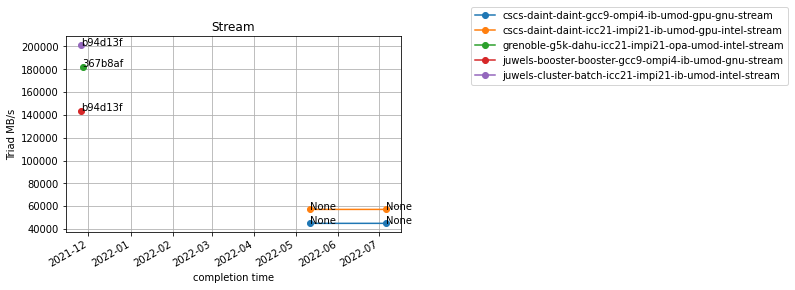

In [5]:
test='Stream'
perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, extras=['array_size'], test=test)
if perf_records is None:
    print('%s: no performance logs found' % test)
fig, ax = plt.subplots(nrows=1, ncols=1)
for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):
    # filter to only Gflops records (might have others)
    data = data.loc[data['perf_var'] == 'Triad']
    data.plot(ax=ax, x='completion_time', y='perf_value', style=['o-'], label='-'.join(spe), legend=None)

    # annotate points with git_ref:
    for x, y, ref in zip(data['completion_time'], data['perf_value'], data['git']):
        if not pd.isnull(ref):
            ax.annotate(ref[:7], (x, y))
ax.set_title(test)
ax.set_xlabel('completion time')
ax.set_ylabel('Triad MB/s')
handles, labels = ax.get_legend_handles_labels()
ax.grid()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')